### Question 3

In [1]:
import numpy as np
import pandas as pd
import random
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
class PCA_cust:
    def __init__(self,K):
        self.eigvecs = None
        self.K=K
    
    def fit(self, x):
        x = x - np.mean(x, axis=0)  # Center the data
        N = len(x)
        
        # Calculate the covariance matrix
        cov = x @ x.T / N
        
        # Calculate the eigenvalues and eigenvectors
        eigvals, eigvecs = np.linalg.eigh(cov)
        
        # Sort the eigenvectors by decreasing eigenvalues
        idx = np.argsort(np.abs(eigvals))[::-1]
        eigvals = eigvals[idx]
        eigvecs = eigvecs[:, idx]
        
        # Select the first (largest) K eigenvectors
        eigvecs = eigvecs[:, :self.K]
        eigvecs = x.T@eigvecs/np.sqrt(N*eigvals[:self.K])
        # Store eigenvectors
        self.eigvecs = eigvecs
        
    def predict(self, x):
        if self.eigvecs is None:
            raise ValueError("Model is not fitted yet.")
        
        # Project the data onto the eigenvectors
        x_projected = np.dot(x, self.eigvecs)
        return x_projected

def load_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
    data = [line.rsplit('\t', 1) for line in lines]
    texts, labels = zip(*data)
    labels = np.array(labels, dtype=int)
    return list(texts), labels

def split_data(texts, labels,num_train = 900):
    combined = list(zip(texts, labels))
    random.shuffle(combined)
    texts, labels = zip(*combined)
    
    train_texts, test_texts = texts[:num_train], texts[num_train:]
    train_labels, test_labels = labels[:num_train], labels[num_train:]
    
    train_texts, val_texts, train_labels, val_labels = train_test_split(
        train_texts, train_labels, test_size=100, random_state=42)
    
    return train_texts, train_labels, val_texts, val_labels, test_texts, test_labels

def extract_tfidf_features(train_texts, val_texts, test_texts):
    vectorizer = TfidfVectorizer()
    X_train = vectorizer.fit_transform(train_texts).toarray()
    X_val = vectorizer.transform(val_texts).toarray()
    X_test = vectorizer.transform(test_texts).toarray()
    return X_train, X_val, X_test

def apply_pca(X_train, X_val, X_test, n_components=30):
    pca = PCA_cust(K=n_components)
    pca.fit(X_train)
    X_train_pca = pca.predict(X_train)
    X_val_pca = pca.predict(X_val)
    X_test_pca = pca.predict(X_test)
    return X_train_pca, X_val_pca, X_test_pca



In [ ]:

file_path = 'movieReviews1000.txt'
texts, labels = load_data(file_path)
train_texts, train_labels, val_texts, val_labels, test_texts, test_labels = split_data(texts, labels)

X_train, X_val, X_test = extract_tfidf_features(train_texts, val_texts, test_texts)

X_train_pca, X_val_pca, X_test_pca = apply_pca(X_train, X_val, X_test)

In [ ]:

class LogisticRegressionSGD:
    def __init__(self, lr=0.01, epochs=10, batch_size=32, l2=0.0):
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.weights = None
        self.bias = None
        self.l2 = l2

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def compute_loss(self, y_true, y_pred):
        loss = -np.mean(y_true * np.log(y_pred + 1e-10) + (1 - y_true) * np.log(1 - y_pred + 1e-10)) 
        l2_penalty = 0.5 * self.l2 * np.sum(self.weights ** 2)
        return loss + l2_penalty
    # Added small value to prevent log(0)


    def fit(self, X, y, X_val, y_val):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0
        y = np.array(y)  
        y_val = np.array(y_val)  
        
        self.train_loss = [] 
        self.val_loss = []  

        for epoch in range(self.epochs):
            indices = np.arange(n_samples)
            np.random.shuffle(indices)
            X, y = X[indices], y[indices]
 
            for i in range(0, n_samples, self.batch_size):
                X_batch = X[i:i+self.batch_size]
                y_batch = y[i:i+self.batch_size]
                
                y_pred = self.sigmoid(np.dot(X_batch, self.weights) + self.bias)
                grad_w = np.dot(X_batch.T, (y_pred - y_batch)) / len(y_batch) + self.l2 * self.weights
                grad_b = np.mean(y_pred - y_batch)
                
                self.weights -= self.lr * grad_w
                self.bias -= self.lr * grad_b


            train_loss = self.compute_loss(y, self.sigmoid(np.dot(X, self.weights) + self.bias))
            val_loss = self.compute_loss(y_val, self.sigmoid(np.dot(X_val, self.weights) + self.bias))

            self.train_loss.append(train_loss)
            self.val_loss.append(val_loss)

            print(f"Epoch {epoch+1}/{self.epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    def predict(self, X):
        return (self.sigmoid(np.dot(X, self.weights) + self.bias) >= 0.5).astype(int)


Training model with batch_size=32, learning_rate=0.001
Epoch 1/20 - Train Loss: 0.6931, Val Loss: 0.6932
Epoch 2/20 - Train Loss: 0.6931, Val Loss: 0.6932
Epoch 3/20 - Train Loss: 0.6931, Val Loss: 0.6932
Epoch 4/20 - Train Loss: 0.6931, Val Loss: 0.6932
Epoch 5/20 - Train Loss: 0.6931, Val Loss: 0.6932
Epoch 6/20 - Train Loss: 0.6931, Val Loss: 0.6932
Epoch 7/20 - Train Loss: 0.6930, Val Loss: 0.6932
Epoch 8/20 - Train Loss: 0.6930, Val Loss: 0.6932
Epoch 9/20 - Train Loss: 0.6930, Val Loss: 0.6932
Epoch 10/20 - Train Loss: 0.6930, Val Loss: 0.6932
Epoch 11/20 - Train Loss: 0.6930, Val Loss: 0.6932
Epoch 12/20 - Train Loss: 0.6930, Val Loss: 0.6932
Epoch 13/20 - Train Loss: 0.6930, Val Loss: 0.6932
Epoch 14/20 - Train Loss: 0.6929, Val Loss: 0.6932
Epoch 15/20 - Train Loss: 0.6929, Val Loss: 0.6933
Epoch 16/20 - Train Loss: 0.6929, Val Loss: 0.6933
Epoch 17/20 - Train Loss: 0.6929, Val Loss: 0.6933
Epoch 18/20 - Train Loss: 0.6929, Val Loss: 0.6933
Epoch 19/20 - Train Loss: 0.6929, Va

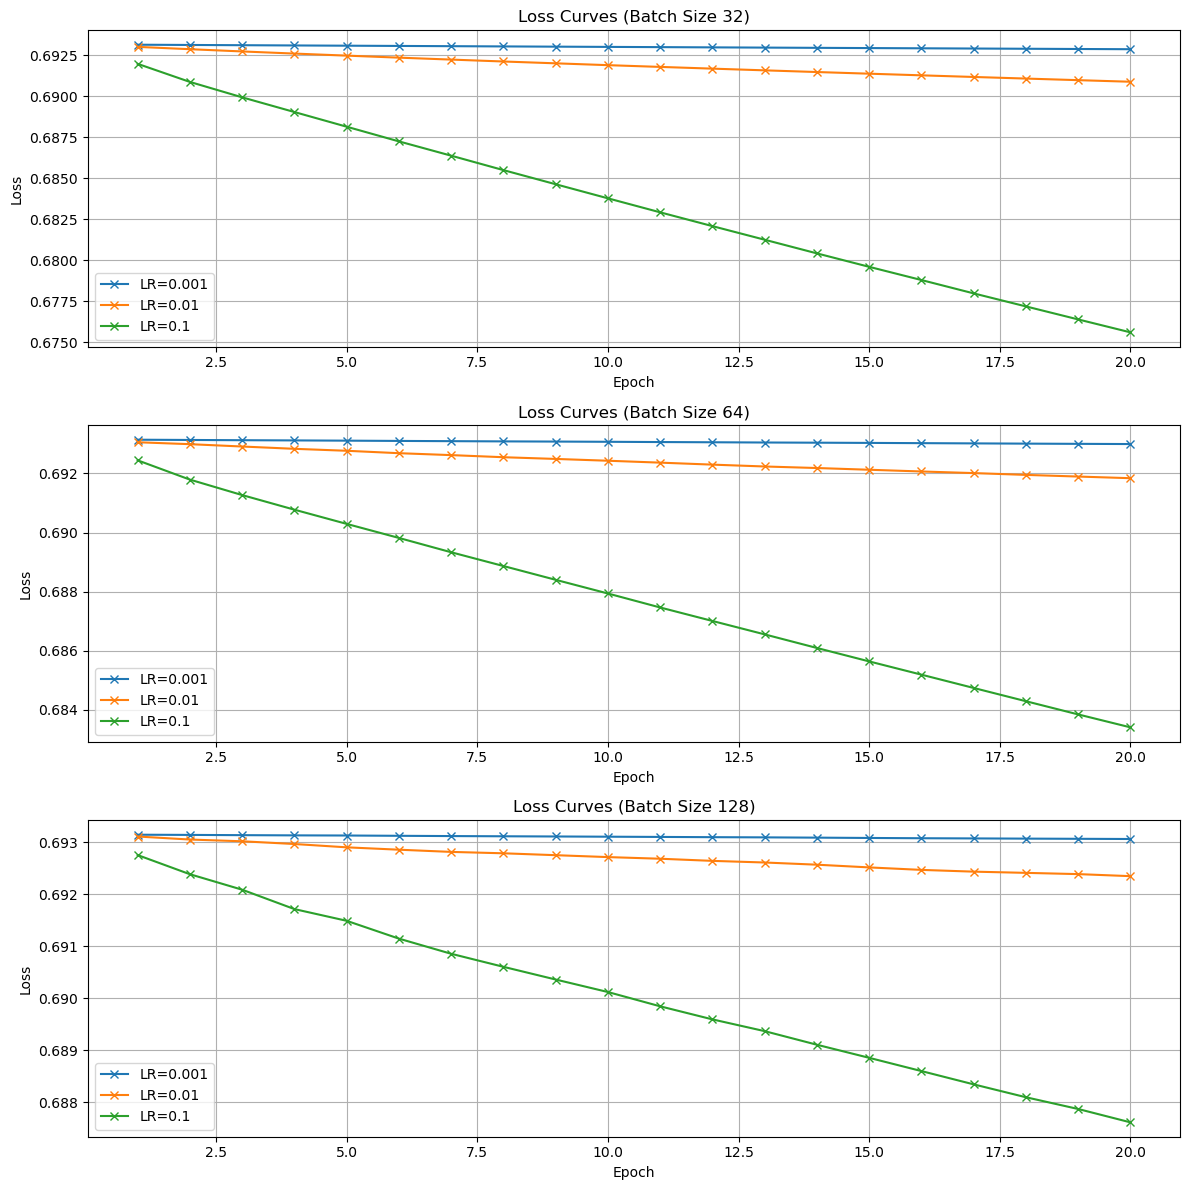

Batch Size: 32, Learning Rate: 0.001, Test Accuracy: 0.4200
Batch Size: 32, Learning Rate: 0.01, Test Accuracy: 0.4200
Batch Size: 32, Learning Rate: 0.1, Test Accuracy: 0.5700
Batch Size: 64, Learning Rate: 0.001, Test Accuracy: 0.4200
Batch Size: 64, Learning Rate: 0.01, Test Accuracy: 0.4200
Batch Size: 64, Learning Rate: 0.1, Test Accuracy: 0.4300
Batch Size: 128, Learning Rate: 0.001, Test Accuracy: 0.4200
Batch Size: 128, Learning Rate: 0.01, Test Accuracy: 0.4200
Batch Size: 128, Learning Rate: 0.1, Test Accuracy: 0.4300


In [47]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = np.mean(y_pred == y_test)
    return accuracy

batch_sizes = [32, 64, 128]
learning_rates = [1e-3, 1e-2, 1e-1]

results = {}

for batch_size in batch_sizes:
    for lr in learning_rates:
        print(f"Training model with batch_size={batch_size}, learning_rate={lr}")
        model = LogisticRegressionSGD(lr=lr, epochs=20, batch_size=batch_size)
        model.fit(X_train_pca, train_labels, X_val_pca, val_labels)
        
        test_accuracy = evaluate_model(model, X_test_pca, test_labels)
        results[(batch_size, lr)] = test_accuracy
        print(f"Test Accuracy: {test_accuracy:.4f}\n")


plt.figure(figsize=(12, 12))
for i, batch_size in enumerate(batch_sizes, 1):
    plt.subplot(3, 1, i)
    for lr in learning_rates:
        model = LogisticRegressionSGD(lr=lr, epochs=20, batch_size=batch_size)
        model.fit(X_train_pca, train_labels, X_val_pca, val_labels)
        plt.plot(range(1, 21), model.train_loss,marker='x', label=f'LR={lr}')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Loss Curves (Batch Size {batch_size})")
    plt.legend()
    
    plt.grid(True)  
plt.tight_layout()
plt.show()

for (batch_size, lr), acc in results.items():
    print(f"Batch Size: {batch_size}, Learning Rate: {lr}, Test Accuracy: {acc:.4f}")


Upon training the logistic regression model, using stochastic gradient descent, we obtain the best accuracy of 57%, using batch size of, learning rate of 0.1.


Training model with batch_size=32, learning_rate=0.001
Epoch 1/20 - Train Loss: 0.6931, Val Loss: 0.6932
Epoch 2/20 - Train Loss: 0.6931, Val Loss: 0.6932
Epoch 3/20 - Train Loss: 0.6931, Val Loss: 0.6932
Epoch 4/20 - Train Loss: 0.6931, Val Loss: 0.6932
Epoch 5/20 - Train Loss: 0.6931, Val Loss: 0.6932
Epoch 6/20 - Train Loss: 0.6931, Val Loss: 0.6932
Epoch 7/20 - Train Loss: 0.6930, Val Loss: 0.6932
Epoch 8/20 - Train Loss: 0.6930, Val Loss: 0.6932
Epoch 9/20 - Train Loss: 0.6930, Val Loss: 0.6932
Epoch 10/20 - Train Loss: 0.6930, Val Loss: 0.6932
Epoch 11/20 - Train Loss: 0.6930, Val Loss: 0.6932
Epoch 12/20 - Train Loss: 0.6930, Val Loss: 0.6932
Epoch 13/20 - Train Loss: 0.6930, Val Loss: 0.6932
Epoch 14/20 - Train Loss: 0.6929, Val Loss: 0.6932
Epoch 15/20 - Train Loss: 0.6929, Val Loss: 0.6933
Epoch 16/20 - Train Loss: 0.6929, Val Loss: 0.6933
Epoch 17/20 - Train Loss: 0.6929, Val Loss: 0.6933
Epoch 18/20 - Train Loss: 0.6929, Val Loss: 0.6933
Epoch 19/20 - Train Loss: 0.6929, Va

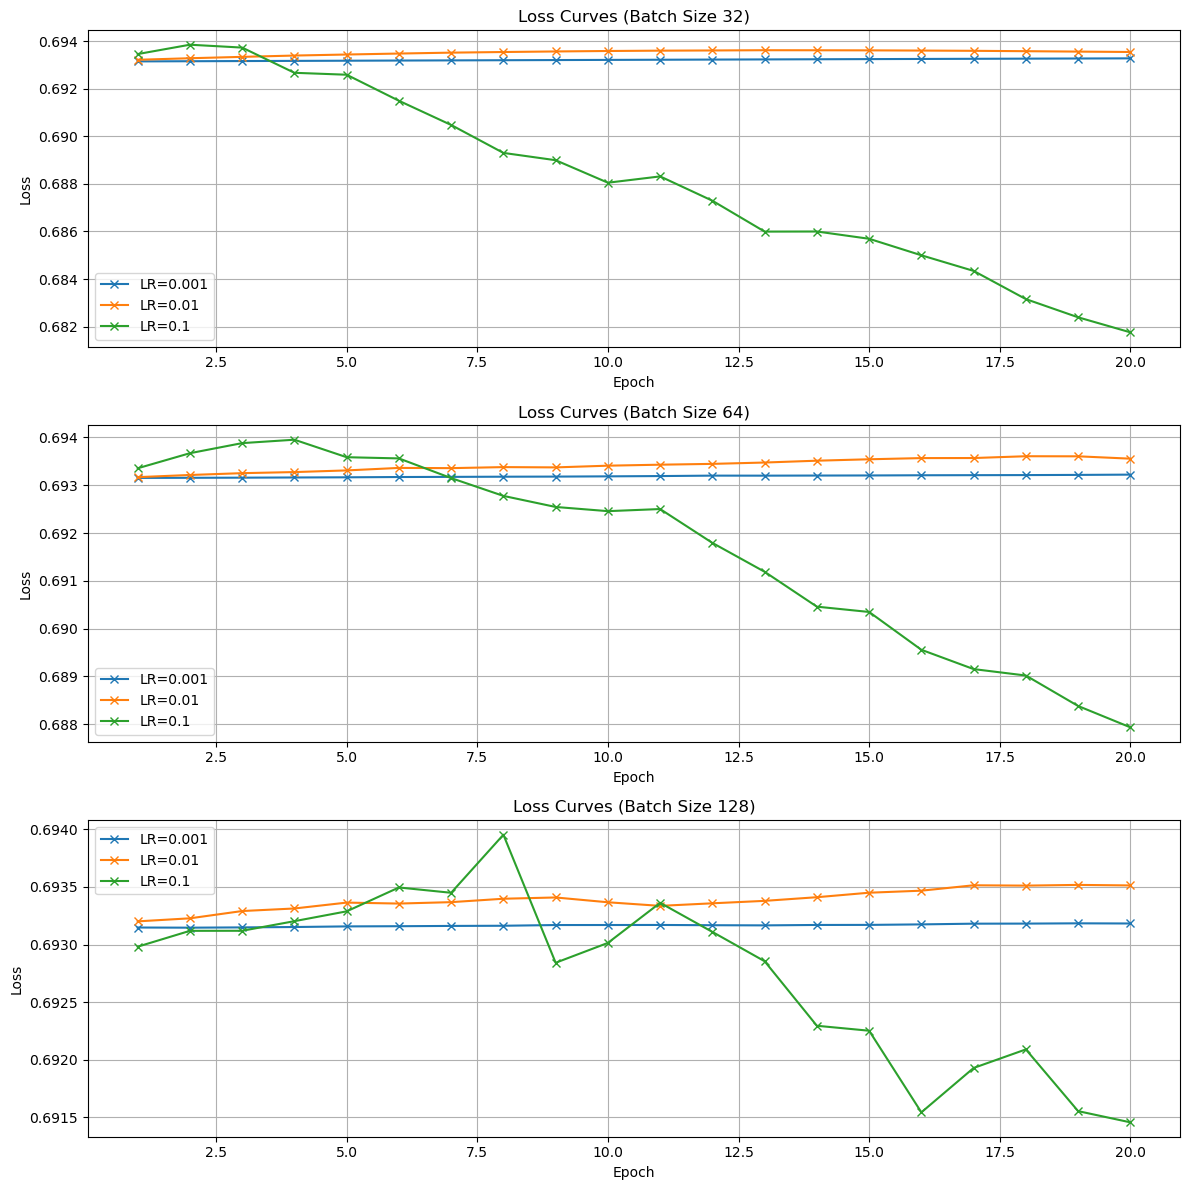

Batch Size: 32, Learning Rate: 0.001, Test Accuracy: 0.4200
Batch Size: 32, Learning Rate: 0.01, Test Accuracy: 0.4200
Batch Size: 32, Learning Rate: 0.1, Test Accuracy: 0.5900
Batch Size: 64, Learning Rate: 0.001, Test Accuracy: 0.4200
Batch Size: 64, Learning Rate: 0.01, Test Accuracy: 0.4200
Batch Size: 64, Learning Rate: 0.1, Test Accuracy: 0.4300
Batch Size: 128, Learning Rate: 0.001, Test Accuracy: 0.4200
Batch Size: 128, Learning Rate: 0.01, Test Accuracy: 0.4200
Batch Size: 128, Learning Rate: 0.1, Test Accuracy: 0.4300


In [48]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = np.mean(y_pred == y_test)
    return accuracy

batch_sizes = [32, 64, 128]
learning_rates = [1e-3, 1e-2, 1e-1]

results = {}

for batch_size in batch_sizes:
    for lr in learning_rates:
        print(f"Training model with batch_size={batch_size}, learning_rate={lr}")
        model = LogisticRegressionSGD(lr=lr, epochs=20, batch_size=batch_size)
        model.fit(X_train_pca, train_labels, X_val_pca, val_labels)
        
        test_accuracy = evaluate_model(model, X_test_pca, test_labels)
        results[(batch_size, lr)] = test_accuracy
        print(f"Test Accuracy: {test_accuracy:.4f}\n")


plt.figure(figsize=(12, 12))
for i, batch_size in enumerate(batch_sizes, 1):
    plt.subplot(3, 1, i)
    for lr in learning_rates:
        model = LogisticRegressionSGD(lr=lr, epochs=20, batch_size=batch_size)
        model.fit(X_train_pca, train_labels, X_val_pca, val_labels)
        plt.plot(range(1, 21), model.val_loss,marker='x', label=f'LR={lr}')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Loss Curves (Batch Size {batch_size})")
    plt.legend()
    
    plt.grid(True)  
plt.tight_layout()
plt.show()

for (batch_size, lr), acc in results.items():
    print(f"Batch Size: {batch_size}, Learning Rate: {lr}, Test Accuracy: {acc:.4f}")


From the accuracy of the testset, it can be observed that the best testing accuracy obtained is for learning rate of  = 0.1 and batch size of 32, giving a testing accuracy of 59%, for this particular seed.

The training loss appears to be monotonically decreasing, as expected with the steepest descent observed with learning rate of 0.1. The validation loss, however, appears to be fluctuating, with eventual decrease for learning rate of 0.1, but slight increase in case of the other two. This suggests that the model has converged in a local minima and the learning rate being too small, doesn't lead to convergence. Thus the model is underfitting.
**Thus the LR=0.1 and batch size of 32 is the best hyperparameter for this particular seed.**

##### The following plots are obtained after implementing regularized logistic regression, for different validation loss varying the lambda (regularizer)magnitude and batch sizes, and within each plot different learning rates are used.

Training model with batch_size=32, learning_rate=0.001, l2 lambda=0.01
Epoch 1/20 - Train Loss: 0.6931, Val Loss: 0.6932
Epoch 2/20 - Train Loss: 0.6931, Val Loss: 0.6932
Epoch 3/20 - Train Loss: 0.6931, Val Loss: 0.6932
Epoch 4/20 - Train Loss: 0.6931, Val Loss: 0.6932
Epoch 5/20 - Train Loss: 0.6931, Val Loss: 0.6932
Epoch 6/20 - Train Loss: 0.6931, Val Loss: 0.6932
Epoch 7/20 - Train Loss: 0.6930, Val Loss: 0.6932
Epoch 8/20 - Train Loss: 0.6930, Val Loss: 0.6932
Epoch 9/20 - Train Loss: 0.6930, Val Loss: 0.6932
Epoch 10/20 - Train Loss: 0.6930, Val Loss: 0.6932
Epoch 11/20 - Train Loss: 0.6930, Val Loss: 0.6932
Epoch 12/20 - Train Loss: 0.6930, Val Loss: 0.6932
Epoch 13/20 - Train Loss: 0.6930, Val Loss: 0.6932
Epoch 14/20 - Train Loss: 0.6929, Val Loss: 0.6932
Epoch 15/20 - Train Loss: 0.6929, Val Loss: 0.6933
Epoch 16/20 - Train Loss: 0.6929, Val Loss: 0.6933
Epoch 17/20 - Train Loss: 0.6929, Val Loss: 0.6933
Epoch 18/20 - Train Loss: 0.6929, Val Loss: 0.6933
Epoch 19/20 - Train 

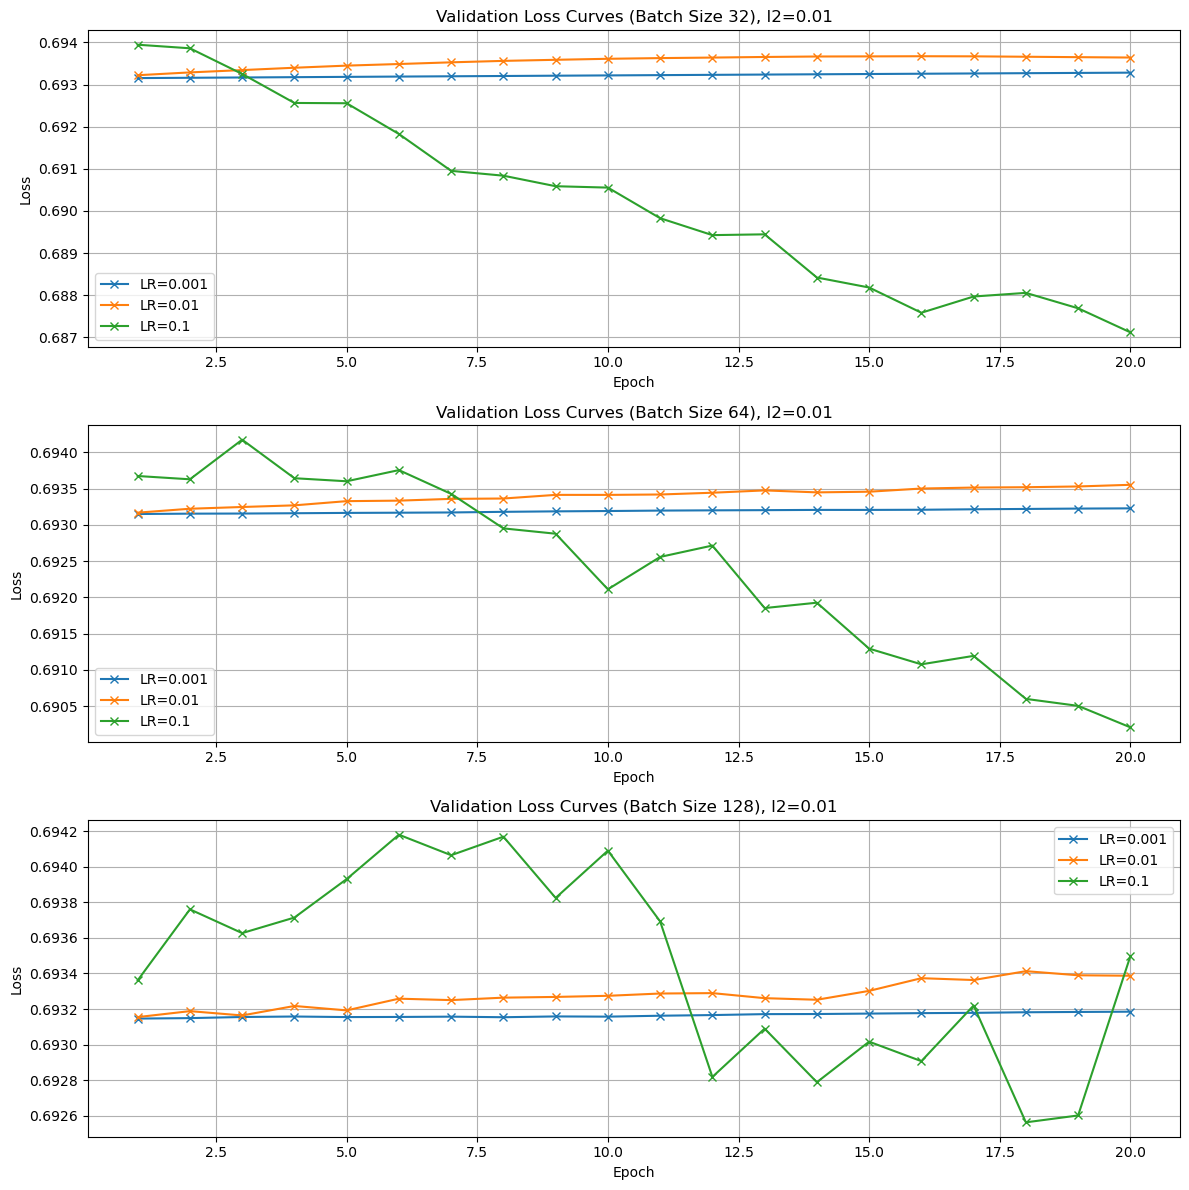

Batch Size: 32, Learning Rate: 0.001, Test Accuracy: 0.4200
Batch Size: 32, Learning Rate: 0.01, Test Accuracy: 0.4200
Batch Size: 32, Learning Rate: 0.1, Test Accuracy: 0.5500
Batch Size: 64, Learning Rate: 0.001, Test Accuracy: 0.4200
Batch Size: 64, Learning Rate: 0.01, Test Accuracy: 0.4200
Batch Size: 64, Learning Rate: 0.1, Test Accuracy: 0.4300
Batch Size: 128, Learning Rate: 0.001, Test Accuracy: 0.4200
Batch Size: 128, Learning Rate: 0.01, Test Accuracy: 0.4200
Batch Size: 128, Learning Rate: 0.1, Test Accuracy: 0.4200
Training model with batch_size=32, learning_rate=0.001, l2 lambda=0.1
Epoch 1/20 - Train Loss: 0.6931, Val Loss: 0.6932
Epoch 2/20 - Train Loss: 0.6931, Val Loss: 0.6932
Epoch 3/20 - Train Loss: 0.6931, Val Loss: 0.6932
Epoch 4/20 - Train Loss: 0.6931, Val Loss: 0.6932
Epoch 5/20 - Train Loss: 0.6931, Val Loss: 0.6932
Epoch 6/20 - Train Loss: 0.6931, Val Loss: 0.6932
Epoch 7/20 - Train Loss: 0.6930, Val Loss: 0.6932
Epoch 8/20 - Train Loss: 0.6930, Val Loss: 0.6

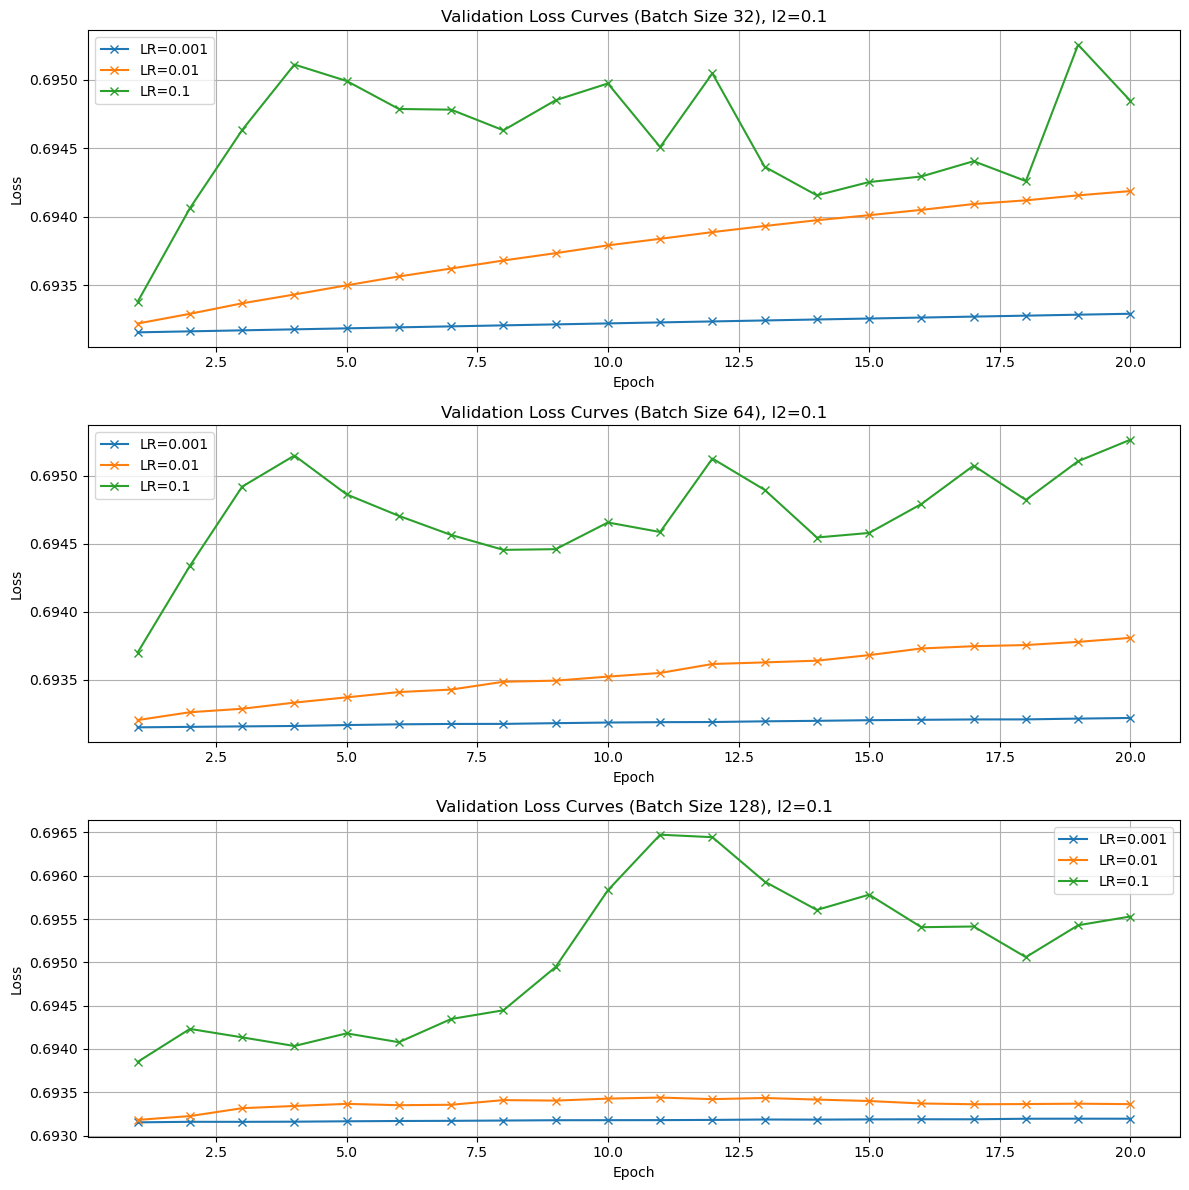

Batch Size: 32, Learning Rate: 0.001, Test Accuracy: 0.4200
Batch Size: 32, Learning Rate: 0.01, Test Accuracy: 0.4200
Batch Size: 32, Learning Rate: 0.1, Test Accuracy: 0.4200
Batch Size: 64, Learning Rate: 0.001, Test Accuracy: 0.4200
Batch Size: 64, Learning Rate: 0.01, Test Accuracy: 0.4200
Batch Size: 64, Learning Rate: 0.1, Test Accuracy: 0.4200
Batch Size: 128, Learning Rate: 0.001, Test Accuracy: 0.4200
Batch Size: 128, Learning Rate: 0.01, Test Accuracy: 0.4200
Batch Size: 128, Learning Rate: 0.1, Test Accuracy: 0.4300
Training model with batch_size=32, learning_rate=0.001, l2 lambda=1
Epoch 1/20 - Train Loss: 0.6931, Val Loss: 0.6932
Epoch 2/20 - Train Loss: 0.6931, Val Loss: 0.6932
Epoch 3/20 - Train Loss: 0.6931, Val Loss: 0.6932
Epoch 4/20 - Train Loss: 0.6931, Val Loss: 0.6932
Epoch 5/20 - Train Loss: 0.6931, Val Loss: 0.6932
Epoch 6/20 - Train Loss: 0.6931, Val Loss: 0.6932
Epoch 7/20 - Train Loss: 0.6931, Val Loss: 0.6932
Epoch 8/20 - Train Loss: 0.6930, Val Loss: 0.693

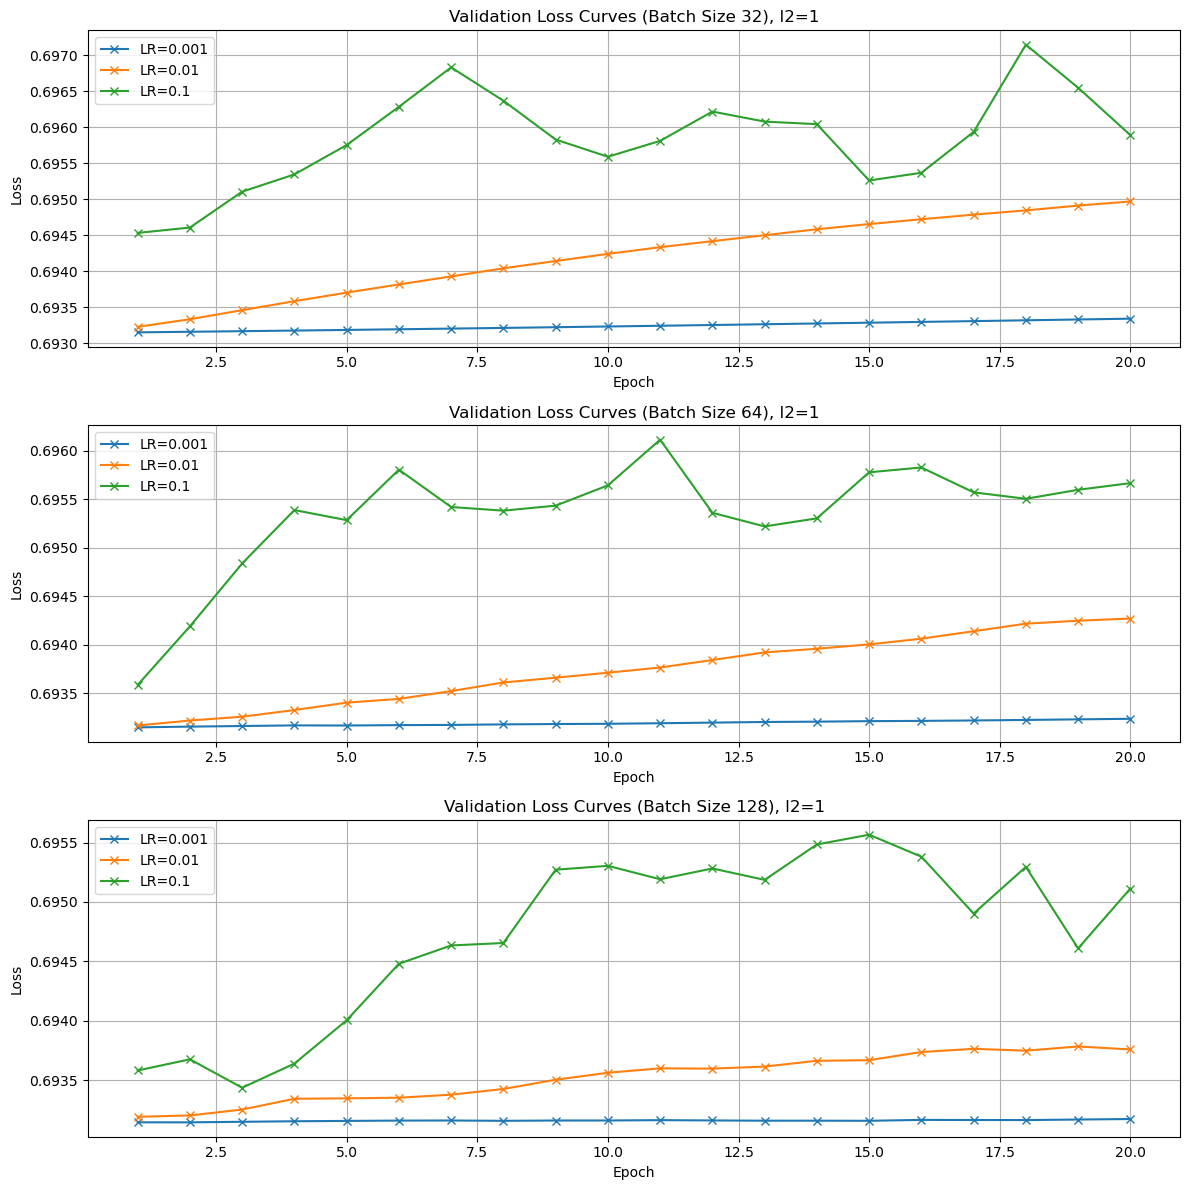

Batch Size: 32, Learning Rate: 0.001, Test Accuracy: 0.4200
Batch Size: 32, Learning Rate: 0.01, Test Accuracy: 0.4200
Batch Size: 32, Learning Rate: 0.1, Test Accuracy: 0.4200
Batch Size: 64, Learning Rate: 0.001, Test Accuracy: 0.4200
Batch Size: 64, Learning Rate: 0.01, Test Accuracy: 0.4200
Batch Size: 64, Learning Rate: 0.1, Test Accuracy: 0.4200
Batch Size: 128, Learning Rate: 0.001, Test Accuracy: 0.4200
Batch Size: 128, Learning Rate: 0.01, Test Accuracy: 0.4200
Batch Size: 128, Learning Rate: 0.1, Test Accuracy: 0.4200


In [52]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = np.mean(y_pred == y_test)
    return accuracy
reg_coeffs = [1e-2, 1e-1, 1]
batch_sizes = [32, 64, 128]
learning_rates = [1e-3, 1e-2, 1e-1]

results = {}
for l2 in reg_coeffs:
    for batch_size in batch_sizes:
        for lr in learning_rates:
            print(f"Training model with batch_size={batch_size}, learning_rate={lr}, l2 lambda={l2}")
            model = LogisticRegressionSGD(lr=lr, epochs=20, batch_size=batch_size, l2=l2)
            model.fit(X_train_pca, train_labels, X_val_pca, val_labels)
            
            test_accuracy = evaluate_model(model, X_test_pca, test_labels)
            results[(batch_size, lr)] = test_accuracy
            print(f"Test Accuracy: {test_accuracy:.4f}\n")


    plt.figure(figsize=(12, 12))
    for i, batch_size in enumerate(batch_sizes, 1):
        plt.subplot(3, 1, i)
        for lr in learning_rates:
            model = LogisticRegressionSGD(lr=lr, epochs=20, batch_size=batch_size, l2=l2)
            model.fit(X_train_pca, train_labels, X_val_pca, val_labels)
            plt.plot(range(1, 21), model.val_loss,marker='x', label=f'LR={lr}')
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title(f"Validation Loss Curves (Batch Size {batch_size}), l2={l2}")
        plt.legend()
        
        plt.grid(True)  
    plt.tight_layout()
    plt.show()

    for (batch_size, lr), acc in results.items():
        print(f"Batch Size: {batch_size}, Learning Rate: {lr}, Test Accuracy: {acc:.4f}")


Training model with batch_size=32, learning_rate=0.001, l2 lambda=0.01
Epoch 1/20 - Train Loss: 0.6931, Val Loss: 0.6932
Epoch 2/20 - Train Loss: 0.6931, Val Loss: 0.6932
Epoch 3/20 - Train Loss: 0.6931, Val Loss: 0.6932
Epoch 4/20 - Train Loss: 0.6931, Val Loss: 0.6932
Epoch 5/20 - Train Loss: 0.6931, Val Loss: 0.6932
Epoch 6/20 - Train Loss: 0.6931, Val Loss: 0.6932
Epoch 7/20 - Train Loss: 0.6930, Val Loss: 0.6932
Epoch 8/20 - Train Loss: 0.6930, Val Loss: 0.6932
Epoch 9/20 - Train Loss: 0.6930, Val Loss: 0.6932
Epoch 10/20 - Train Loss: 0.6930, Val Loss: 0.6932
Epoch 11/20 - Train Loss: 0.6930, Val Loss: 0.6932
Epoch 12/20 - Train Loss: 0.6930, Val Loss: 0.6932
Epoch 13/20 - Train Loss: 0.6930, Val Loss: 0.6932
Epoch 14/20 - Train Loss: 0.6929, Val Loss: 0.6932
Epoch 15/20 - Train Loss: 0.6929, Val Loss: 0.6933
Epoch 16/20 - Train Loss: 0.6929, Val Loss: 0.6933
Epoch 17/20 - Train Loss: 0.6929, Val Loss: 0.6933
Epoch 18/20 - Train Loss: 0.6929, Val Loss: 0.6933
Epoch 19/20 - Train 

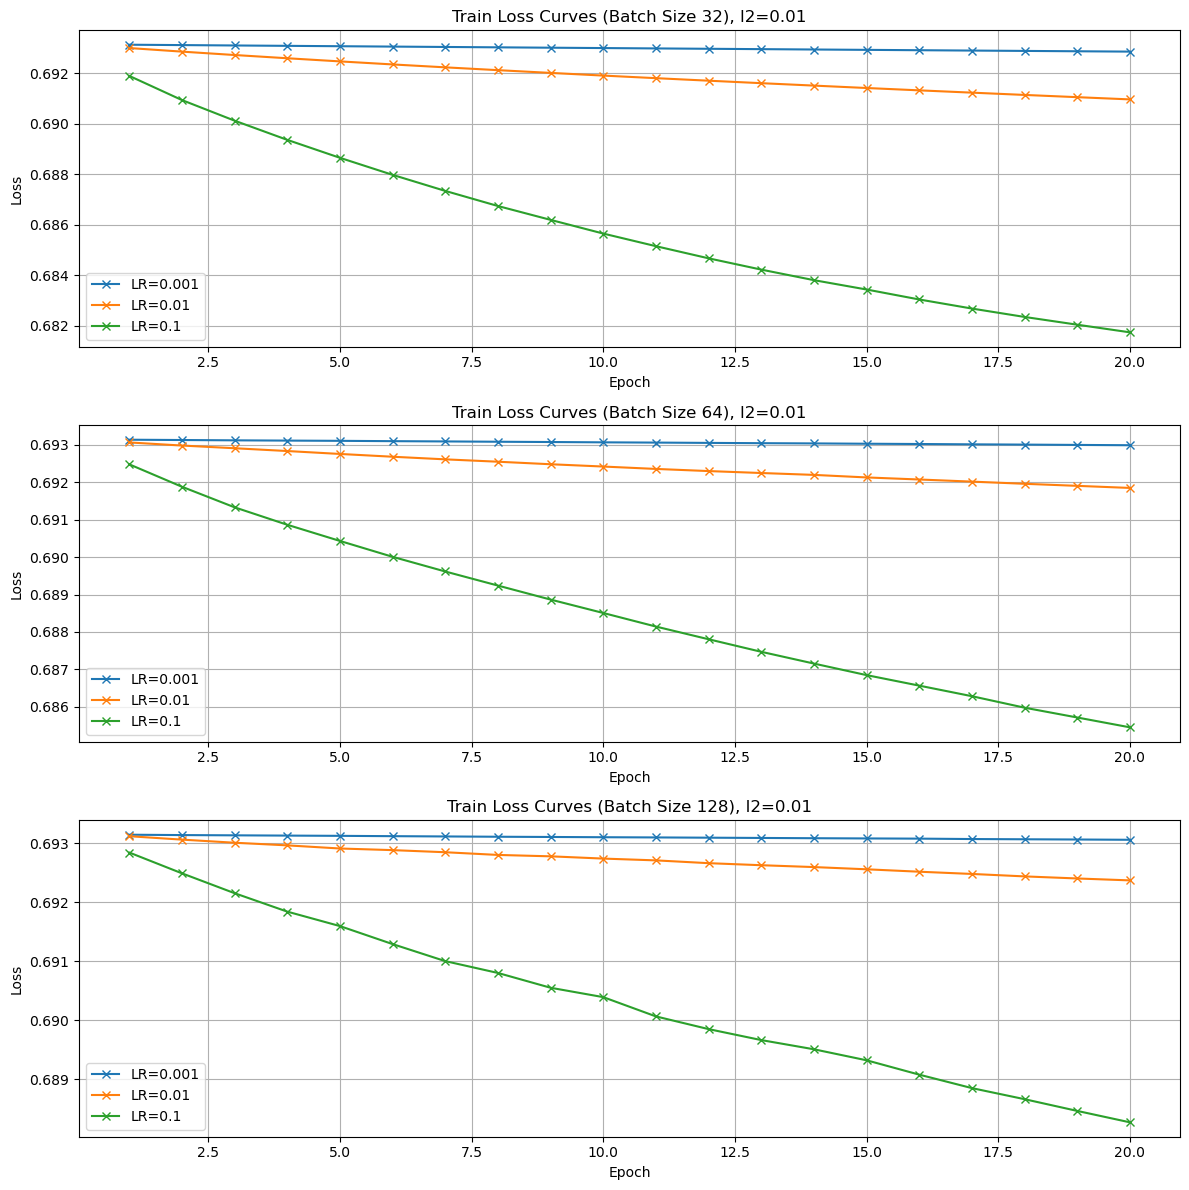

Batch Size: 32, Learning Rate: 0.001, Test Accuracy: 0.4200
Batch Size: 32, Learning Rate: 0.01, Test Accuracy: 0.4200
Batch Size: 32, Learning Rate: 0.1, Test Accuracy: 0.5200
Batch Size: 64, Learning Rate: 0.001, Test Accuracy: 0.4200
Batch Size: 64, Learning Rate: 0.01, Test Accuracy: 0.4200
Batch Size: 64, Learning Rate: 0.1, Test Accuracy: 0.4300
Batch Size: 128, Learning Rate: 0.001, Test Accuracy: 0.4200
Batch Size: 128, Learning Rate: 0.01, Test Accuracy: 0.4200
Batch Size: 128, Learning Rate: 0.1, Test Accuracy: 0.4300
Training model with batch_size=32, learning_rate=0.001, l2 lambda=0.1
Epoch 1/20 - Train Loss: 0.6931, Val Loss: 0.6932
Epoch 2/20 - Train Loss: 0.6931, Val Loss: 0.6932
Epoch 3/20 - Train Loss: 0.6931, Val Loss: 0.6932
Epoch 4/20 - Train Loss: 0.6931, Val Loss: 0.6932
Epoch 5/20 - Train Loss: 0.6931, Val Loss: 0.6932
Epoch 6/20 - Train Loss: 0.6931, Val Loss: 0.6932
Epoch 7/20 - Train Loss: 0.6930, Val Loss: 0.6932
Epoch 8/20 - Train Loss: 0.6930, Val Loss: 0.6

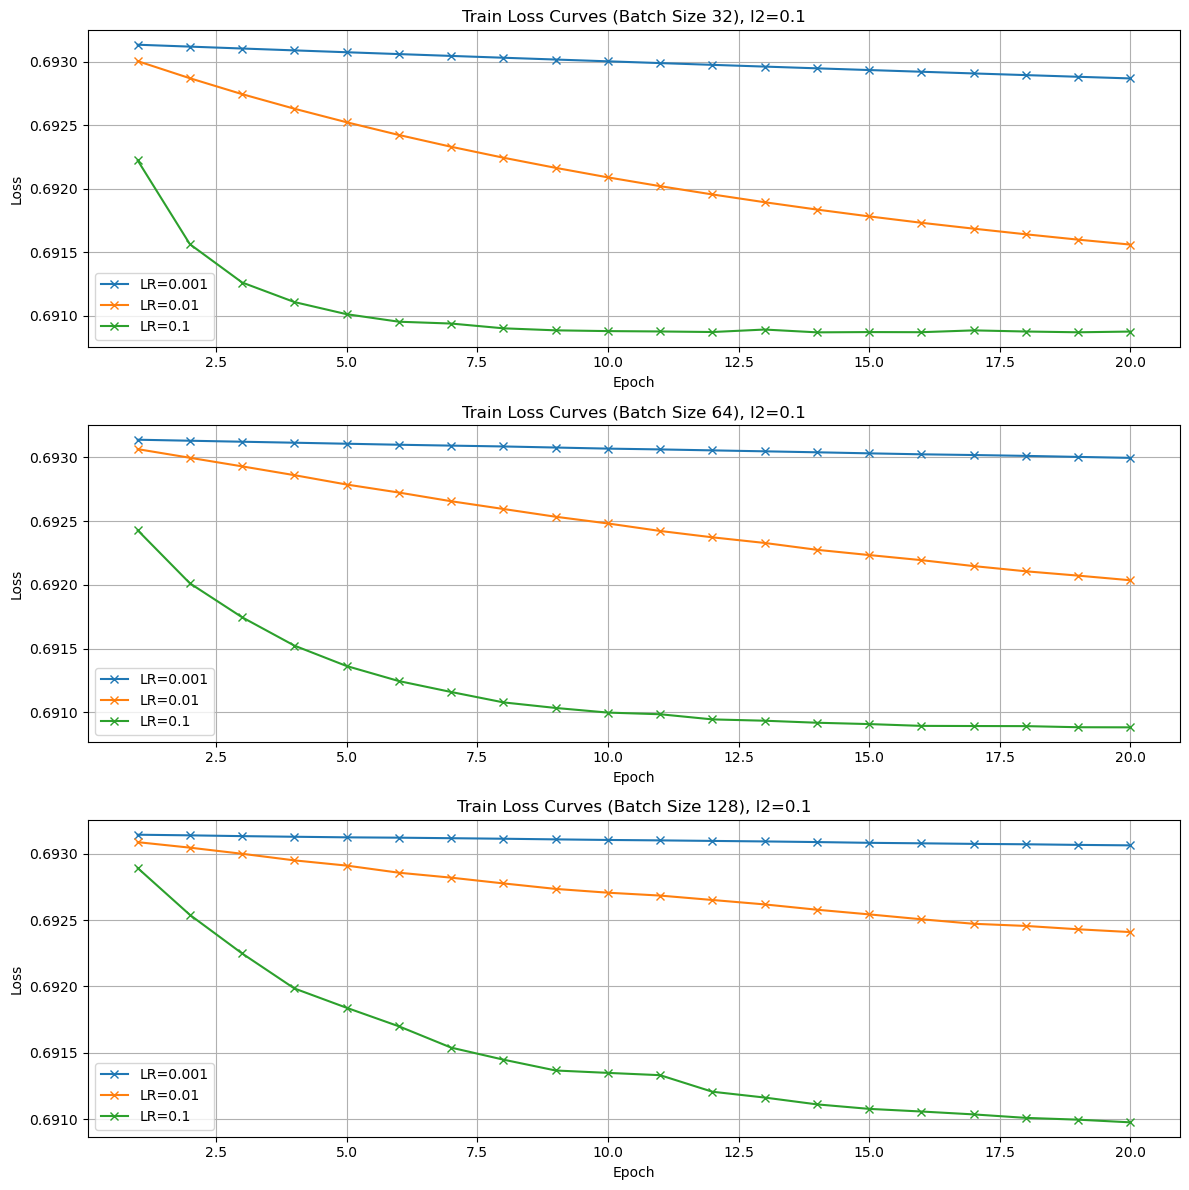

Batch Size: 32, Learning Rate: 0.001, Test Accuracy: 0.4200
Batch Size: 32, Learning Rate: 0.01, Test Accuracy: 0.4200
Batch Size: 32, Learning Rate: 0.1, Test Accuracy: 0.4200
Batch Size: 64, Learning Rate: 0.001, Test Accuracy: 0.4200
Batch Size: 64, Learning Rate: 0.01, Test Accuracy: 0.4200
Batch Size: 64, Learning Rate: 0.1, Test Accuracy: 0.4200
Batch Size: 128, Learning Rate: 0.001, Test Accuracy: 0.4200
Batch Size: 128, Learning Rate: 0.01, Test Accuracy: 0.4200
Batch Size: 128, Learning Rate: 0.1, Test Accuracy: 0.4200
Training model with batch_size=32, learning_rate=0.001, l2 lambda=1
Epoch 1/20 - Train Loss: 0.6931, Val Loss: 0.6932
Epoch 2/20 - Train Loss: 0.6931, Val Loss: 0.6932
Epoch 3/20 - Train Loss: 0.6931, Val Loss: 0.6932
Epoch 4/20 - Train Loss: 0.6931, Val Loss: 0.6932
Epoch 5/20 - Train Loss: 0.6931, Val Loss: 0.6932
Epoch 6/20 - Train Loss: 0.6931, Val Loss: 0.6932
Epoch 7/20 - Train Loss: 0.6931, Val Loss: 0.6932
Epoch 8/20 - Train Loss: 0.6930, Val Loss: 0.693

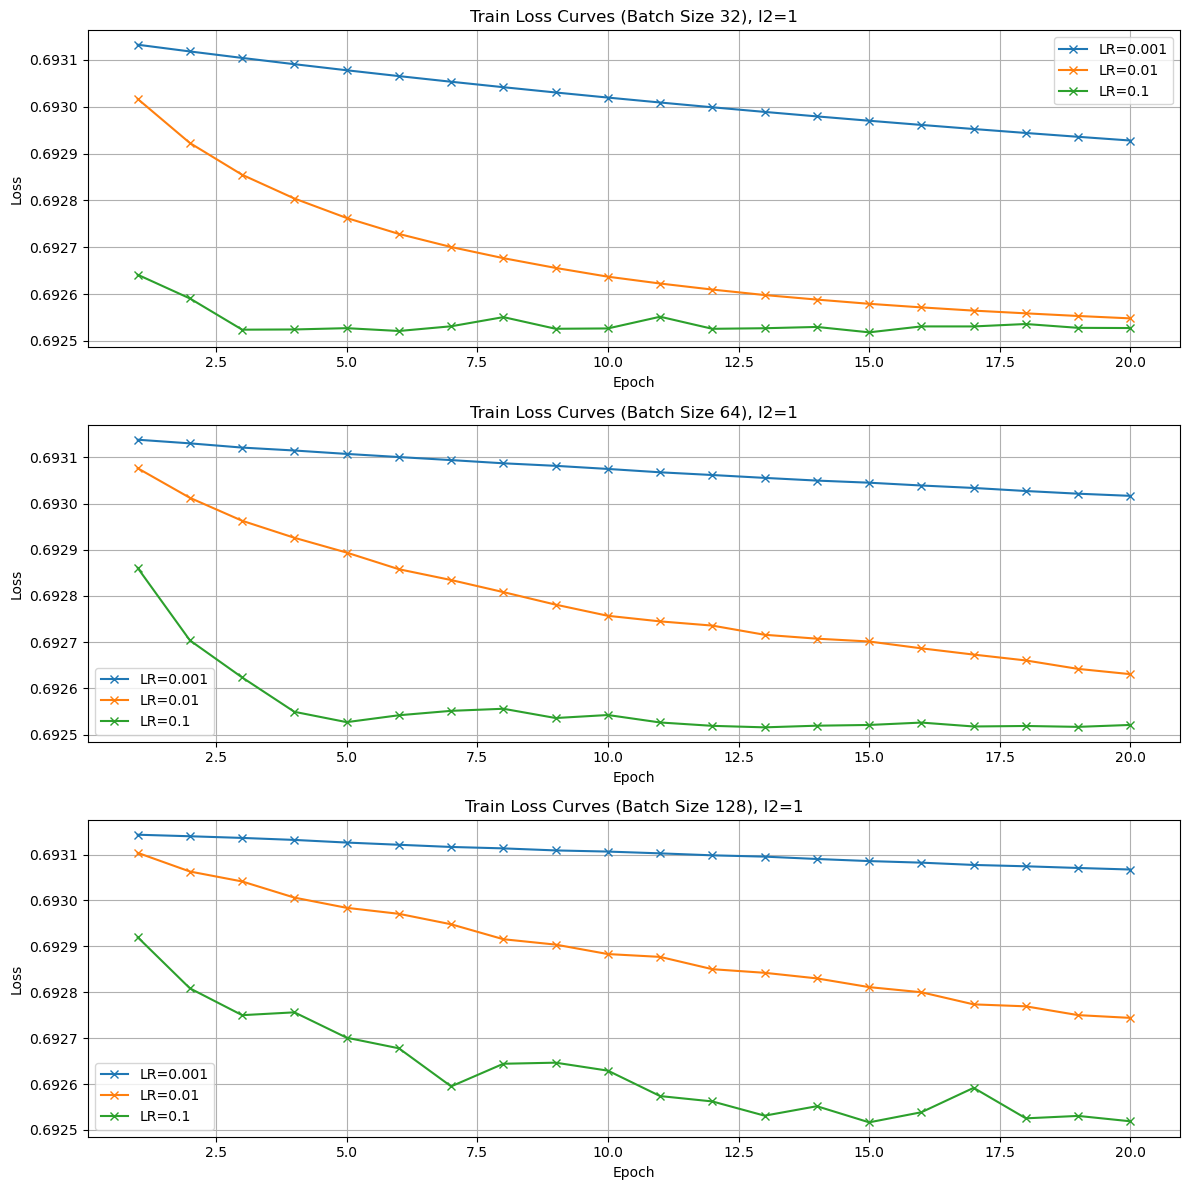

Batch Size: 32, Learning Rate: 0.001, Test Accuracy: 0.4200
Batch Size: 32, Learning Rate: 0.01, Test Accuracy: 0.4200
Batch Size: 32, Learning Rate: 0.1, Test Accuracy: 0.4200
Batch Size: 64, Learning Rate: 0.001, Test Accuracy: 0.4200
Batch Size: 64, Learning Rate: 0.01, Test Accuracy: 0.4200
Batch Size: 64, Learning Rate: 0.1, Test Accuracy: 0.4200
Batch Size: 128, Learning Rate: 0.001, Test Accuracy: 0.4200
Batch Size: 128, Learning Rate: 0.01, Test Accuracy: 0.4200
Batch Size: 128, Learning Rate: 0.1, Test Accuracy: 0.4200


In [53]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = np.mean(y_pred == y_test)
    return accuracy
reg_coeffs = [1e-2, 1e-1, 1]
batch_sizes = [32, 64, 128]
learning_rates = [1e-3, 1e-2, 1e-1]

results = {}
for l2 in reg_coeffs:
    for batch_size in batch_sizes:
        for lr in learning_rates:
            print(f"Training model with batch_size={batch_size}, learning_rate={lr}, l2 lambda={l2}")
            model = LogisticRegressionSGD(lr=lr, epochs=20, batch_size=batch_size, l2=l2)
            model.fit(X_train_pca, train_labels, X_val_pca, val_labels)
            
            test_accuracy = evaluate_model(model, X_test_pca, test_labels)
            results[(batch_size, lr)] = test_accuracy
            print(f"Test Accuracy: {test_accuracy:.4f}\n")


    plt.figure(figsize=(12, 12))
    for i, batch_size in enumerate(batch_sizes, 1):
        plt.subplot(3, 1, i)
        for lr in learning_rates:
            model = LogisticRegressionSGD(lr=lr, epochs=20, batch_size=batch_size, l2=l2)
            model.fit(X_train_pca, train_labels, X_val_pca, val_labels)
            plt.plot(range(1, 21), model.train_loss,marker='x', label=f'LR={lr}')
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title(f"Train Loss Curves (Batch Size {batch_size}), l2={l2}")
        plt.legend()
        
        plt.grid(True)  
    plt.tight_layout()
    plt.show()

    for (batch_size, lr), acc in results.items():
        print(f"Batch Size: {batch_size}, Learning Rate: {lr}, Test Accuracy: {acc:.4f}")


The test accuracy reduces from before, since the model had been underfitting, and adding regularizer led to further underfitting.
On the training loss curves, a smotth convergence can be observed for all the learning rates, with steepest descent and fastest convergence for learning rate of 0.1. The validation loss curves, however, are fluctuating, with eventual increase for all learning rates. The performance is thus worse.
However, this is a good strategy if the initial model had been overfitting.